In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn import cross_validation
import sqlite3

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm

import seaborn as sn
import nltk
import string
#from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_recall_fscore_support

C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Simha\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
conn=sqlite3.connect('final.sqlite')

filter_data=pd.read_sql_query(""" Select * from Reviews where Score!=3""",conn)

In [3]:
print(filter_data.shape)
filter_data.head(3)

(364171, 13)


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [4]:
#fetching some random subset of records from total input, as our system config is less
sliced_data,useful_data= cross_validation.train_test_split(filter_data,test_size=0.16,random_state=4)

print(useful_data.shape)

(58268, 13)


In [5]:
#Converting date field from seconds format to standard date format.
useful_data['Time']=pd.to_datetime(useful_data.Time)


#Sort the data now based on time stamp
sorted_usefuldata=useful_data.sort_values(by='Time',ascending=True,axis=0,inplace=False,kind='quicksort',na_position='last')

sorted_usefuldata['Score'].value_counts()

1    49057
0     9211
Name: Score, dtype: int64

In [6]:
#Renaming finalised data variable name.
fin_data=sorted_usefuldata

In [7]:
#Splitting sorted data into train and test subsets
lim=58268*0.8
print(round(lim))
fin_train=fin_data[:round(lim)]
print('size of over all train dataset :: ',round(lim))
fin_test=fin_data[round(lim):]

print('size of test dataset :: ',fin_test.shape[0])




train_x=fin_train[:round(fin_train.shape[0]*0.7)]
valid_x=fin_train[round(fin_train.shape[0]*0.7):]

print('\nsize of train dataset :: ',train_x.shape[0])
print('\nsize of Validation dataset :: ',valid_x.shape[0])

#storing our actual polarity of reviews into seperate variables and used as Y column in KNN

all_train_y=fin_train['Score']
test_y=fin_test['Score']

train_y=all_train_y[:32630]
valid_y=all_train_y[32630:]

print(train_y.shape)
print('\n',valid_y.shape)
print('\n',test_y.shape)

46614
size of over all train dataset ::  46614
size of test dataset ::  11654

size of train dataset ::  32630

size of Validation dataset ::  13984
(32630,)

 (13984,)

 (11654,)


In [8]:
# Converting input into Data frame for easy proccessing by dropping Y  column

train_x=pd.DataFrame(train_x, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time','Summary', 'Text', 'CleanedText'])
valid_x=pd.DataFrame(valid_x, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time','Summary', 'Text', 'CleanedText'])
fin_test=pd.DataFrame(fin_test, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time','Summary', 'Text', 'CleanedText'])


print('Size of Train data :',train_x.shape,' Type of train data :',type(train_x))
print('Size of validation data :',valid_x.shape,' Type of validation data :',type(valid_x))
print('Size of Test data :',fin_test.shape,' Type of test dataset :',type(fin_test))

Size of Train data : (32630, 12)  Type of train data : <class 'pandas.core.frame.DataFrame'>
Size of validation data : (13984, 12)  Type of validation data : <class 'pandas.core.frame.DataFrame'>
Size of Test data : (11654, 12)  Type of test dataset : <class 'pandas.core.frame.DataFrame'>


# Implementing BOW and then applying KNN on it.

In [45]:
bow_model=CountVectorizer()

fin_train_counts=bow_model.fit_transform(train_x['CleanedText'].values)

fin_valid_counts=bow_model.transform(valid_x['CleanedText'].values)

fin_test_counts=bow_model.transform(fin_test['CleanedText'].values)

print("the type of train count vectorizer ",type(fin_train_counts))
print("the shape of train out text BOW vectorizer ",fin_train_counts.get_shape())
print("the number of unique words in train data set  ", fin_train_counts.get_shape()[1])


print("\n\nthe type of validation count vectorizer ",type(fin_valid_counts))
print("the shape of validation out text BOW vectorizer ",fin_valid_counts.get_shape())
print("the number of unique words in validation data set  ", fin_valid_counts.get_shape()[1])



print("\n\nthe type of test count vectorizer ",type(fin_test_counts))
print("the shape of test out text BOW vectorizer ",fin_test_counts.get_shape())
print("the number of unique words in test dataset ", fin_test_counts.get_shape()[1])

the type of train count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train out text BOW vectorizer  (32630, 22431)
the number of unique words in train data set   22431


the type of validation count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of validation out text BOW vectorizer  (13984, 22431)
the number of unique words in validation data set   22431


the type of test count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of test out text BOW vectorizer  (11654, 22431)
the number of unique words in test dataset  22431


In [10]:
#Applying KNN
scores=[]
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm="brute")

    # fitting the model on crossvalidation train
    knn.fit(fin_train_counts, train_y)

    # predict the response on the crossvalidation train
    pred = knn.predict(fin_valid_counts)
    # ---  https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba

    # from above link we can decide F1_Score will be useful for finding pred prob of our model.
    valid_f1score=f1_score(valid_y,pred)
    print('F1 score for validation data on training data with k=%d is'%(i),valid_f1score)
    


F1 score for validation data on training data with k=1 is 0.8875715114832933
F1 score for validation data on training data with k=3 is 0.9026250301035562
F1 score for validation data on training data with k=5 is 0.9042633653118904
F1 score for validation data on training data with k=7 is 0.9052598225602028
F1 score for validation data on training data with k=9 is 0.9053562964133354
F1 score for validation data on training data with k=11 is 0.9050605451031437
F1 score for validation data on training data with k=13 is 0.9045780474351903
F1 score for validation data on training data with k=15 is 0.9046812866648294
F1 score for validation data on training data with k=17 is 0.9043122442555871
F1 score for validation data on training data with k=19 is 0.9039414680198252
F1 score for validation data on training data with k=21 is 0.9036495202139374
F1 score for validation data on training data with k=23 is 0.9032587758952788
F1 score for validation data on training data with k=25 is 0.90336018

In [46]:
# So frrom above executions we can consider k=9 as optimal value

#now we will apply our test dataset on our fit.

knn_model=KNeighborsClassifier(n_neighbors=9,algorithm='brute')
knn_model.fit(fin_train_counts, train_y)

pred=knn_model.predict(fin_test_counts)



In [47]:
# Now we will calculate confusion matrix, precission, recall, tpr,fpr here 
# using our test prediction with respect to actual values.
print('#################################################################################################')

print(' Final output after applying KNN with algorithm type = "BRUTE"')
tn, fp, fn, tp=confusion_matrix(test_y,pred).ravel()

print('\n Confusion matrix for test data is : [%d, %d, %d, %d]\n'%(tp,fn,fp,tn))

prec=precision_recall_fscore_support(test_y,pred)

print('\n precision : ',prec[0])
print('\n Recall : ',prec[1])

prs=roc_curve(test_y,pred)

print('\n TPR value is : ',prs[0][1])
print('\n FPR value is :',prs[1][1])

ppv=tp/(tp+fp)
npv=tn/(tn+fn)

print('\n true prob value : %f and False prob value : %f'%(ppv,npv))

f1=f1_score(test_y,pred)

print('\n F1 Score of test data with k= 9 is  : ',f1)
acc=accuracy_score(test_y,pred,normalize=True) * float(100)

print('\n Accuracy of test data with k= 9 is  : ',f1)


print('##################################################################################################')

#################################################################################################
 Final output after applying KNN with algorithm type = "BRUTE"

 Confusion matrix for test data is : [9601, 35, 1922, 96]


 precision :  [0.73282443 0.83320316]

 Recall :  [0.04757185 0.99636779]

 TPR value is :  0.9524281466798811

 FPR value is : 0.9963677874636778

 true prob value : 0.833203 and False prob value : 0.732824

 F1 Score of test data with k= 9 is  :  0.9075098067016399

 Accuracy of test data with k= 9 is  :  0.9075098067016399
##################################################################################################


In [19]:
# Function for plotting Confusion Matrix
# Using this snipped of code copied from kaggle
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

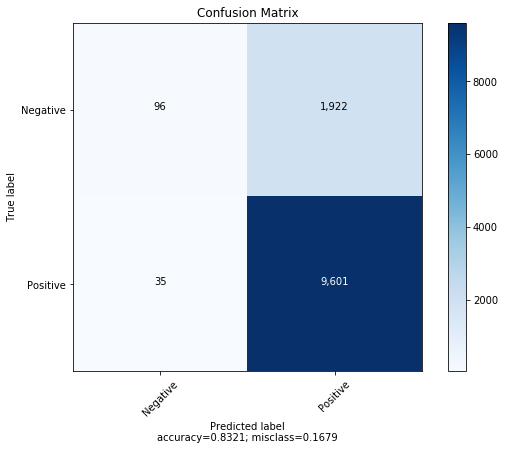

In [49]:
Conf_matrix=confusion_matrix(test_y, pred)
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

[[  96 1922]
 [  35 9601]]


Predicted,0,1,All
True,,,
0,96,1922,2018
1,35,9601,9636
All,131,11523,11654


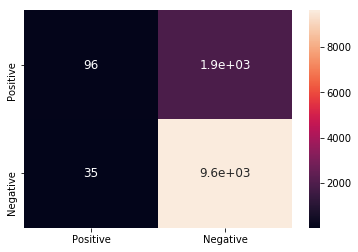

In [50]:
print(Conf_matrix)
import seaborn as sn
cm=pd.DataFrame(Conf_matrix,index=['Positive','Negative'],columns=['Positive','Negative'])

sn.heatmap(cm,annot=True,annot_kws={"size": 12})#font-size

pd.crosstab(test_y, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [51]:
print(classification_report(test_y, pred))  

             precision    recall  f1-score   support

          0       0.73      0.05      0.09      2018
          1       0.83      1.00      0.91      9636

avg / total       0.82      0.83      0.77     11654



# Tfidf with KNN


In [10]:
# Fitting a tfidf model and transforming our input data into that model on both test ad train datasets

tf_model=TfidfVectorizer(ngram_range=(1,2))

fin_train_counts=tf_model.fit_transform(train_x['CleanedText'].values)

fin_valid_counts=tf_model.transform(valid_x['CleanedText'].values)

fin_test_counts=tf_model.transform(fin_test['CleanedText'].values)

print("the type of train count vectorizer ",type(fin_train_counts))
print("the shape of train out text BOW vectorizer ",fin_train_counts.get_shape())
print("the number of unique words in train data set  ", fin_train_counts.get_shape()[1])


print("\n\nthe type of valid count vectorizer ",type(fin_valid_counts))
print("the shape of validation out text BOW vectorizer ",fin_valid_counts.get_shape())
print("the number of unique words in validation dataset ", fin_valid_counts.get_shape()[1])

print("\n\nthe type of test count vectorizer ",type(fin_test_counts))
print("the shape of test out text BOW vectorizer ",fin_test_counts.get_shape())
print("the number of unique words in test dataset ", fin_test_counts.get_shape()[1])

the type of train count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train out text BOW vectorizer  (32630, 567305)
the number of unique words in train data set   567305


the type of valid count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of validation out text BOW vectorizer  (13984, 567305)
the number of unique words in validation dataset  567305


the type of test count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of test out text BOW vectorizer  (11654, 567305)
the number of unique words in test dataset  567305


# Applying KNN on tfidf data

In [19]:
#Applying KNN
cv_scores=[]
for i in range(1,30,2):
    knn_model=KNeighborsClassifier(n_neighbors=i,algorithm='brute')#creating model template
    
    #fit model for validation
    knn_model.fit(fin_train_counts,train_y)
    
    #Now, predict using validation data
    pred=knn_model.predict(fin_valid_counts)
    #accuracy calculation
    acc = accuracy_score(valid_y, pred, normalize=True) * float(100)
    print('\nAccuracy for k = %d for train data on Validation dataset is - '%(i),acc)
    cv_scores.append(acc)
    #print('\nfpr for k %d is '%(i),fpr)
    #print('\n')


Accuracy for k = 1 for train data on Validation dataset is -  79.94136155606407

Accuracy for k = 3 for train data on Validation dataset is -  83.35240274599542

Accuracy for k = 5 for train data on Validation dataset is -  84.17477116704805

Accuracy for k = 7 for train data on Validation dataset is -  84.29633867276888

Accuracy for k = 9 for train data on Validation dataset is -  84.18907322654462

Accuracy for k = 11 for train data on Validation dataset is -  84.09610983981693

Accuracy for k = 13 for train data on Validation dataset is -  84.16046910755148

Accuracy for k = 15 for train data on Validation dataset is -  83.96024027459954

Accuracy for k = 17 for train data on Validation dataset is -  83.83152173913044

Accuracy for k = 19 for train data on Validation dataset is -  83.74570938215103

Accuracy for k = 21 for train data on Validation dataset is -  83.73855835240275

Accuracy for k = 23 for train data on Validation dataset is -  83.66704805491992

Accuracy for k = 25 


The optimal number of neighbors is 7.


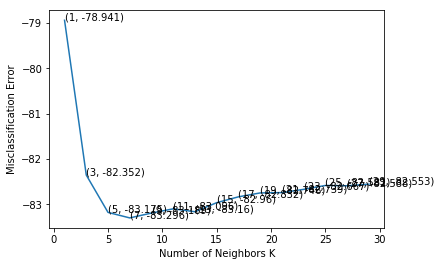

the misclassification error for each k value is :  [-78.941 -82.352 -83.175 -83.296 -83.189 -83.096 -83.16  -82.96  -82.832
 -82.746 -82.739 -82.667 -82.581 -82.588 -82.553]


In [21]:
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))


# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [11]:
# So frrom above executions we can consider k=7 as optimal value with F1-score as 84.29

#now we will apply our test dataset on our fit.

knn_model=KNeighborsClassifier(n_neighbors=7,algorithm='brute')
knn_model.fit(fin_train_counts,train_y)

pred=knn_model.predict(fin_test_counts)


In [12]:
# Now we will calculate confusion matrix, precission, recall, tpr,fpr here 
# using our test prediction with respect to actual values.
print('#################################################################################################')

print(' Final output after applying KNN with algorithm type = "BRUTE"')
tn, fp, fn, tp=confusion_matrix(test_y,pred).ravel()

print('\nConfusion matrix for test data is : [%d, %d, %d, %d]\n'%(tp,fn,fp,tn))

prec=precision_recall_fscore_support(test_y,pred)

print('\n precision : ',prec[0])
print('\n Recall : ',prec[1])

prs=roc_curve(test_y,pred)

print('\n TPR value is : ',prs[0][1])
print('\n FPR value is :',prs[1][1])

ppv=tp/(tp+fp)
npv=tn/(tn+fn)

print('\n true prob value : %f and False prob value : %f'%(ppv,npv))

f1=f1_score(test_y,pred)

print('\n F1 Score of test data with k= 7 is  : ',f1)
acc=accuracy_score(test_y,pred,normalize=True) * float(100)

print('\n Accuracy of test data with k= 7 is  : ',f1)


print('##################################################################################################')

#################################################################################################
 Final output after applying KNN with algorithm type = "BRUTE"

Confusion matrix for test data is : [9518, 118, 1678, 340]


 precision :  [0.74235808 0.85012504]

 Recall :  [0.16848365 0.98775425]

 TPR value is :  0.8315163528245788

 FPR value is : 0.9877542548775425

 true prob value : 0.850125 and False prob value : 0.742358

 F1 Score of test data with k= 7 is  :  0.9137864823348695

 Accuracy of test data with k= 7 is  :  0.9137864823348695
##################################################################################################


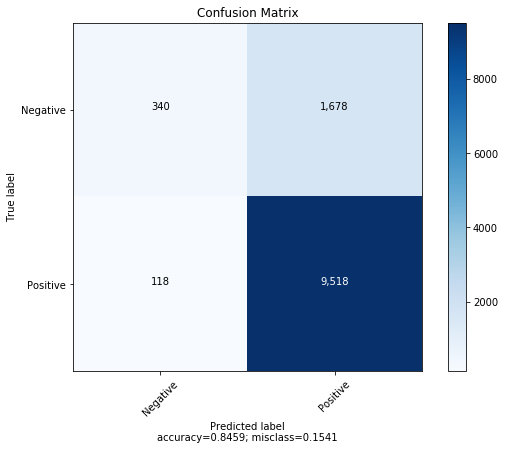

In [42]:
Conf_matrix=confusion_matrix(test_y, pred)
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

In [ ]:
print(Conf_matrix)
import seaborn as sn
cm=pd.DataFrame(Conf_matrix,index=['Positive','Negative'],columns=['Positive','Negative'])

sn.heatmap(cm,annot=True,annot_kws={"size": 12})#font-size

pd.crosstab(test_y, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [44]:
print(classification_report(test_y, pred))  

             precision    recall  f1-score   support

          0       0.74      0.17      0.27      2018
          1       0.85      0.99      0.91      9636

avg / total       0.83      0.85      0.80     11654



# Avg W2v with KNN

In [9]:
list_of_sent_train=[]
for sent in train_x['CleanedText'].values:  #Splitting each sentence into set of individual words
    list_of_sent_train.append(sent.split())
    
print(train_x['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

#Applying Same logic on cv data

list_of_sent_cv=[]
for sent in valid_x['CleanedText'].values:  #Splitting each sentence into set of individual words
    list_of_sent_cv.append(sent.split())
    
print(valid_x['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_cv[0])


# Applying same logic on test data

list_of_sent_test=[]
for sent in fin_test['CleanedText'].values:  #Splitting each sentence into set of individual words
    list_of_sent_test.append(sent.split())
    
print(fin_test['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_test[0])


# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)

# min_count = 5 considers only words that occured atleast 5 times
w2v_model_cv=Word2Vec(list_of_sent_cv,min_count=5,size=50, workers=4)

# min_count = 5 considers only words that occured atleast 5 times
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)


#Applying models on datasets( Train,CV,Test )

w2v_words_train = list(w2v_model_train.wv.vocab)
print("\n number of words that occured minimum 5 times in train data: ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])



w2v_words_cv = list(w2v_model_cv.wv.vocab)
print("\nnumber of words that occured minimum 5 times in cv data : ",len(w2v_words_cv))
print("\nsample words ", w2v_words_cv[0:50])


w2v_words_test = list(w2v_model_test.wv.vocab)
print("\nnumber of words that occured minimum 5 times in test data :  ",len(w2v_words_test))
print("\nsample words ", w2v_words_test[0:50])

rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live
*****************************************************************
['rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'book', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas', 'along', 'book', 'children', 'tradit', 'live']
review describ content pineappl pack well pineappl chunk most stick togeth sugar content color piec rang fade yellow beig caramel brown flatter fresh pineappl chunk absolut delici kind food eat one chunk time clump togeth almost like put wad mouth chew awesom activ outdoor excel sourc quick energi pack bought expir date year guarante youll happi product buy pineappl product may see altern item amazon terribl
*****************************************************************
[

In [10]:
#Calculating AvgW2v

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████| 32630/32630 [01:32<00:00, 353.41it/s]


32630
50


In [11]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████| 13984/13984 [00:42<00:00, 331.80it/s]


13984
50


In [12]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████| 11654/11654 [00:34<00:00, 341.04it/s]


11654
50


# Applying KNN on AvgW2V

In [13]:
#Applying KNN
cv_scores=[]
for i in range(1,30,2):
    knn_model=KNeighborsClassifier(n_neighbors=i,algorithm='brute')#creating model template
    
    #fit model for validation
    knn_model.fit(sent_vectors_train,train_y)
    
    #Now, predict using validation data
    pred=knn_model.predict(sent_vectors_cv)
    acc = accuracy_score(valid_y, pred, normalize=True) * float(100)
    print('\nAccuracy for k = %d for train data on Validation dataset is - '%(i),acc)
    cv_scores.append(acc)


Accuracy for k = 1 for train data on Validation dataset is -  81.11413043478261

Accuracy for k = 3 for train data on Validation dataset is -  84.13186498855835

Accuracy for k = 5 for train data on Validation dataset is -  84.86127002288329

Accuracy for k = 7 for train data on Validation dataset is -  85.23312356979405

Accuracy for k = 9 for train data on Validation dataset is -  85.51201372997713

Accuracy for k = 11 for train data on Validation dataset is -  85.4762585812357

Accuracy for k = 13 for train data on Validation dataset is -  85.52631578947368

Accuracy for k = 15 for train data on Validation dataset is -  85.38329519450801

Accuracy for k = 17 for train data on Validation dataset is -  85.2974828375286

Accuracy for k = 19 for train data on Validation dataset is -  85.19736842105263

Accuracy for k = 21 for train data on Validation dataset is -  85.15446224256293

Accuracy for k = 23 for train data on Validation dataset is -  85.04719679633868

Accuracy for k = 25 fo


The optimal number of neighbors is 13.


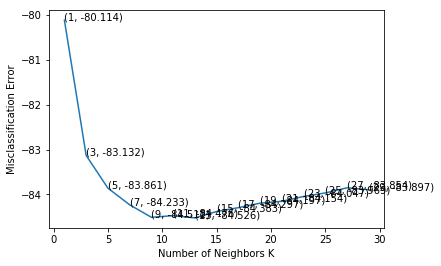

the misclassification error for each k value is :  [-80.114 -83.132 -83.861 -84.233 -84.512 -84.476 -84.526 -84.383 -84.297
 -84.197 -84.154 -84.047 -83.969 -83.854 -83.897]


In [14]:
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))


# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [15]:
# So frrom above executions we can consider k=13 as optimal value with F1-score as 83.48

#now we will apply our test dataset on our fit.

knn_model=KNeighborsClassifier(n_neighbors=13,algorithm='brute')
knn_model.fit(sent_vectors_train,train_y)

pred=knn_model.predict(sent_vectors_test)

In [17]:
# Now we will calculate confusion matrix, precission, recall, tpr,fpr here 
# using our test prediction with respect to actual values.
print('#################################################################################################')

print('## Final output after applying KNN with algorithm type = "BRUTE"')
tn, fp, fn, tp=confusion_matrix(test_y,pred).ravel()

print('\n Confusion matrix for test data is : [%d, %d, %d, %d]\n'%(tp,fn,fp,tn))

prec=precision_recall_fscore_support(test_y,pred)

print('\n precision : ',prec[0])
print('\n Recall : ',prec[1])

prs=roc_curve(test_y,pred)

print('\n TPR value is : ',prs[0][1])
print('\n FPR value is :',prs[1][1])

ppv=tp/(tp+fp)
npv=tn/(tn+fn)

print('\n true prob value : %f and False prob value : %f'%(ppv,npv))

f1=f1_score(test_y,pred)

print('\n F1 Score of test data with k= 13 is  : ',f1)

acc=accuracy_score(test_y,pred,normalize=True) * float(100)

print('\n Accuracy of test data with k= 13 is  : ',f1)

print('#################################################################################################')

#################################################################################################
## Final output after applying KNN with algorithm type = "BRUTE"

 Confusion matrix for test data is : [9444, 192, 1468, 550]


 precision :  [0.74123989 0.86546921]

 Recall :  [0.27254708 0.98007472]

 TPR value is :  0.7274529236868187

 FPR value is : 0.9800747198007472

 true prob value : 0.865469 and False prob value : 0.741240

 F1 Score of test data with k= 13 is  :  0.91921354876387

 Accuracy of test data with k= 13 is  :  0.91921354876387
#################################################################################################


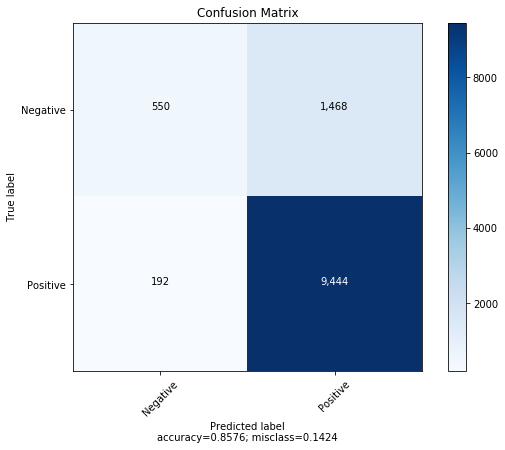

In [20]:
Conf_matrix=confusion_matrix(test_y, pred)
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

[[ 550 1468]
 [ 192 9444]]


Predicted,0,1,All
True,,,
0,550,1468,2018
1,192,9444,9636
All,742,10912,11654


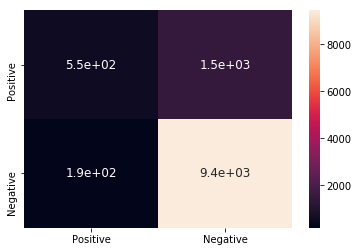

In [21]:
print(Conf_matrix)
import seaborn as sn
cm=pd.DataFrame(Conf_matrix,index=['Positive','Negative'],columns=['Positive','Negative'])

sn.heatmap(cm,annot=True,annot_kws={"size": 12})#font-size

pd.crosstab(test_y, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [22]:
print(classification_report(test_y, pred))  

             precision    recall  f1-score   support

          0       0.74      0.27      0.40      2018
          1       0.87      0.98      0.92      9636

avg / total       0.84      0.86      0.83     11654



# Tfidf weighted Avg W2v

In [22]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_tr = TfidfVectorizer()
tf_idf_train_matrix = model_tr.fit_transform(train_x['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
train_dictionary = dict(zip(model_tr.get_feature_names(), list(model_tr.idf_)))

#Now create dictionary on validation data
tf_idf_valid_matrix = model_tr.transform(valid_x['CleanedText'].values)

#Creating dictionary on test data
tf_idf_test_matrix = model_tr.transform(fin_test['CleanedText'].values)


In [23]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model_tr.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = train_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 32630/32630 [02:07<00:00, 256.20it/s]


In [24]:
tfidf_sent_vectors_val = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = train_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_val.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 13984/13984 [00:55<00:00, 250.09it/s]


In [25]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = train_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 11654/11654 [00:44<00:00, 259.89it/s]


# Applying KNN on tfidf weighted w2v

In [26]:
#Applying KNN
cv_scores=[]
for i in range(1,30,2):
    knn_model=KNeighborsClassifier(n_neighbors=i,algorithm='brute')#creating model template
    
    #fit model for validation
    knn_model.fit(tfidf_sent_vectors_tr,train_y)
    
    #Now, predict using validation data
    pred=knn_model.predict(tfidf_sent_vectors_val)
    acc = accuracy_score(valid_y, pred, normalize=True) * float(100)
    print('\nAccuracy for k = %d for train data on Validation dataset is - '%(i),acc)
    cv_scores.append(acc)


Accuracy for k = 1 for train data on Validation dataset is -  78.9616704805492

Accuracy for k = 3 for train data on Validation dataset is -  82.15818077803205

Accuracy for k = 5 for train data on Validation dataset is -  83.22368421052632

Accuracy for k = 7 for train data on Validation dataset is -  83.64559496567506

Accuracy for k = 9 for train data on Validation dataset is -  83.99599542334096

Accuracy for k = 11 for train data on Validation dataset is -  84.18907322654462

Accuracy for k = 13 for train data on Validation dataset is -  84.21052631578947

Accuracy for k = 15 for train data on Validation dataset is -  84.18907322654462

Accuracy for k = 17 for train data on Validation dataset is -  84.21767734553775

Accuracy for k = 19 for train data on Validation dataset is -  84.2462814645309

Accuracy for k = 21 for train data on Validation dataset is -  84.25343249427918

Accuracy for k = 23 for train data on Validation dataset is -  84.29633867276888

Accuracy for k = 25 fo


The optimal number of neighbors is 23.


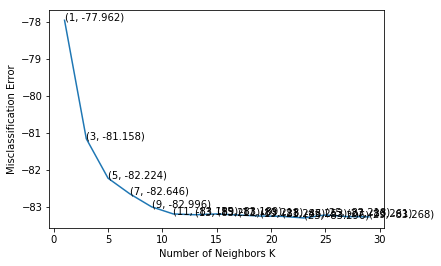

the misclassification error for each k value is :  [-77.962 -81.158 -82.224 -82.646 -82.996 -83.189 -83.211 -83.189 -83.218
 -83.246 -83.253 -83.296 -83.218 -83.261 -83.268]


In [27]:
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))


# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [28]:
# So frrom above executions we can consider k=23 as optimal value with F1-score as 84.296

#now we will apply our test dataset on our fit.

knn_model=KNeighborsClassifier(n_neighbors=23,algorithm='brute')
knn_model.fit(tfidf_sent_vectors_tr,train_y)

pred=knn_model.predict(tfidf_sent_vectors_test)

In [34]:
# Now we will calculate confusion matrix, precission, recall, tpr,fpr here 
# using our test prediction with respect to actual values.
print('#################################################################################################')

print('## Final output after applying KNN with algorithm type = "BRUTE"')
tn, fp, fn, tp=confusion_matrix(test_y,pred).ravel()

print('\n Confusion matrix for test data is : [%d, %d, %d, %d]\n'%(tp,fn,fp,tn))

prec=precision_recall_fscore_support(test_y,pred)

print('\n precision : ',prec[0])
print('\n Recall : ',prec[1])

prs=roc_curve(test_y,pred)

print('\n TPR value is : ',prs[0][1])
print('\n FPR value is :',prs[1][1])

ppv=tp/(tp+fp)
npv=tn/(tn+fn)

print('\n true prob value : %f and False prob value : %f'%(ppv,npv))

f1=f1_score(test_y,pred)

print('\n F1 Score of test data with k= 23 is  : ',f1)

acc=accuracy_score(test_y,pred,normalize=True) * float(100)

print('\n Accuracy of test data with k= 23 is  : ',f1)

print('#################################################################################################')

#################################################################################################
## Final output after applying KNN with algorithm type = "BRUTE"

 Confusion matrix for test data is : [9494, 142, 1620, 398]


 precision :  [0.73703704 0.8542379 ]

 Recall :  [0.19722498 0.98526359]

 TPR value is :  0.8027750247770069

 FPR value is : 0.9852635948526359

 true prob value : 0.854238 and False prob value : 0.737037

 F1 Score of test data with k= 23 is  :  0.9150843373493976

 Accuracy of test data with k= 23 is  :  0.9150843373493976
#################################################################################################


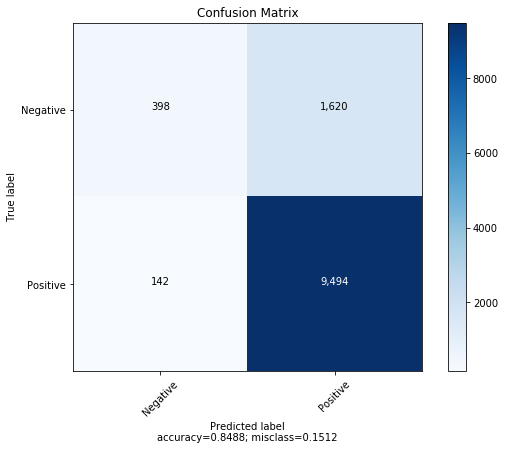

In [31]:
Conf_matrix=confusion_matrix(test_y, pred)
plot_confusion_matrix(cm           = Conf_matrix, 
                      normalize    = False,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

[[ 398 1620]
 [ 142 9494]]


Predicted,0,1,All
True,,,
0,398,1620,2018
1,142,9494,9636
All,540,11114,11654


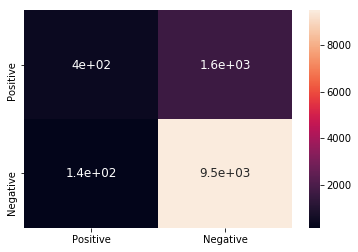

In [32]:
print(Conf_matrix)
import seaborn as sn
cm=pd.DataFrame(Conf_matrix,index=['Positive','Negative'],columns=['Positive','Negative'])

sn.heatmap(cm,annot=True,annot_kws={"size": 12})#font-size

pd.crosstab(test_y, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [33]:
print(classification_report(test_y, pred))  

             precision    recall  f1-score   support

          0       0.74      0.20      0.31      2018
          1       0.85      0.99      0.92      9636

avg / total       0.83      0.85      0.81     11654



# Conclusion

In [23]:

from prettytable import PrettyTable

x=PrettyTable()

x.field_names=["Vectorizer","Model","Hyper Parameters","Accuracy/F1-score"]

x.add_row(['BOW','BRUTE','9','90.75'])
x.add_row(['TFIDF','BRUTE','7','91.37'])
x.add_row(['Avg-W2V','BRUTE','13','91.92'])
x.add_row(['Tfidf weighted W2V','BRUTE','23','91.5'])
print('** Conclusion : Accuracy for Amazon review dataset with different vectorizers \n')
print(x)


** Conclusion : Accuracy for Amazon review dataset with different vectorizers 

+--------------------+-------+------------------+-------------------+
|     Vectorizer     | Model | Hyper Parameters | Accuracy/F1-score |
+--------------------+-------+------------------+-------------------+
|        BOW         | BRUTE |        9         |       90.75       |
|       TFIDF        | BRUTE |        7         |       91.37       |
|      Avg-W2V       | BRUTE |        13        |       91.92       |
| Tfidf weighted W2V | BRUTE |        23        |        91.5       |
+--------------------+-------+------------------+-------------------+
